In [ ]:
import tensorflow as tf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(12345)

In [ ]:
import sys
sys.path.insert(1,'/content/')
from data_utils import parse_imdb_sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


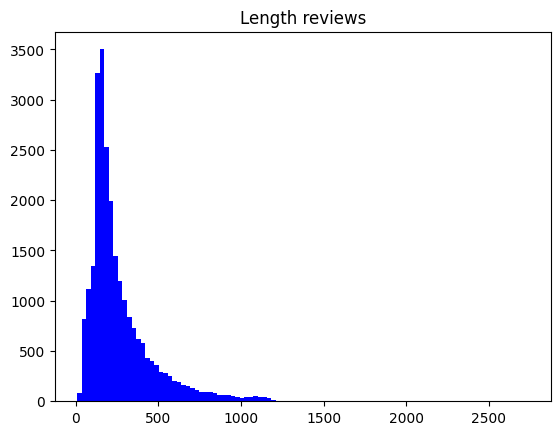

In [ ]:
length_reviews = pickle.load(open('/content/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [ ]:
full_train_dataset = tf.data.TFRecordDataset('/content/train.tfrecords')
full_train_dataset = full_train_dataset.shuffle(buffer_size=1000)
DATASET_SIZE = 25000
train_size = int(0.9 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
train_dataset = full_train_dataset.take(train_size)
val_dataset = full_train_dataset.skip(train_size)

In [ ]:
print(train_dataset)
print(val_dataset)

<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_SkipDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(1024, padded_shapes=([None],[],[]))
val_dataset = val_dataset.map(parse_imdb_sequence).shuffle(buffer_size=1000)
val_dataset = val_dataset.padded_batch(1024, padded_shapes=([None],[],[]))
test_dataset = tf.data.TFRecordDataset('/content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(1024, padded_shapes=([None],[],[]))
print(test_dataset)

<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/word2idx.pkl', 'rb'))

## RNN model for sequence classification, compatible with Eager API 
----
In the cell below, you can find the class that I have created for the RNN model. The API is very similar with one I created in the previous tutorial, except that now we track the accuracy of the model instead of the loss.

The idea of the network is very simple. We simply take each word in the review, select its corresponding word embedding (initialized randomly in the beginning), and pass it through the RNN cell. We then take the output of the RNN cell at the end of the sequence and pass it through a dense layer (with ReLU activation) to obtain the final predictions. 

Like usually, the network inherits from tf.keras.Model in order to keep track of all variables and save/restore them easily.

![img](https://github.com/AnkurMali/Intro_to_DL/blob/main/Assignment_1000/tutorials_graphics/rnn_imdb.png?raw=1)

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size_1=64, dense_size_2 = 64, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None, checkpoint_prefix = None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer,
                                                    )
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size_1, activation=tf.nn.sigmoid,
                                                 kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer,
                                                 kernel_regularizer = tf.keras.regularizers.l2(0.01))
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size_2, activation=tf.nn.sigmoid,
                                                 kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer,
                                                 kernel_regularizer = tf.keras.regularizers.l2(0.01))
      
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None,
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.checkpoint_prefix = checkpoint_prefix
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        if (is_training):
            dropped_output = tf.compat.v1.layers.Dropout(rate=0.3)(final_output, training=is_training)
            final_output = dropped_output

        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits

    @tf.function
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss

    
    @tf.function
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)

    
    @tf.function
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    @tf.function
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False, ckpoint=None):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    logits = tf.nn.softmax(logits)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    logits = tf.nn.softmax(logits)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])
                    ckpoint.save(file_prefix=self.checkpoint_prefix)

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train model with gradient descent and early stopping
----

### Model training with simple RNN cells
----

In [ ]:
# Specify the path where you want to save/restore the trained variables.
import os




checkpoint_directory = '/content/models_checkpoints/ImdbRNN/'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
rnn_model = RNNModel(dense_size_2 = 64, vocabulary_size=len(word2idx), rnn_cell='rnn', device=device,
                      checkpoint_directory=checkpoint_directory, checkpoint_prefix = checkpoint_prefix)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=rnn_model)
checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# Train model
rnn_model.fit(train_dataset, val_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True, ckpoint = checkpoint)

In [ ]:
def predict_fc(test_data, model):
#Function which calulates the test accuracy
    acc_test = tf.keras.metrics.Accuracy('test_acc')
    history = {}
    history['test_acc'] = []
        
    # Begin training
    with tf.device(model.device):
        for step, (X, y, seq_length) in enumerate(test_data):
            logits = model.predict(X, seq_length, False)
            logits = tf.nn.softmax(logits)
            preds = tf.argmax(logits, axis=1)
            acc_test(preds, y)
        history['test_acc'].append(acc_test.result().numpy())

    print('Test accuracy %f: '% history['test_acc'][-1])


In [ ]:
### Create a predict function and test on test_dataset for RNN
# TODO
predict_fc(test_dataset, rnn_model)


Test accuracy 0.851400: 


### Model training with LSTM cells 
---

In [ ]:
# Define optimizer.
checkpoint_directory = '/content/models_checkpoints/ImdbLSTM/'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(embedding_size = 50, cell_size = 32 ,dense_size_2 = 32, vocabulary_size=len(word2idx), rnn_cell='lstm', 
                       device=device, checkpoint_directory=checkpoint_directory, checkpoint_prefix = checkpoint_prefix)

In [ ]:
# Train model
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=lstm_model)
checkpoint.save(file_prefix=checkpoint_prefix)
lstm_model.fit(train_dataset, val_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True,ckpoint = checkpoint)

### Performance comparison
---

In [ ]:
### Create a predict function and test on test_dataset for LSTM
# TODO
predict_fc(test_dataset, lstm_model)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Val Accuracy');
ax2.plot(range(len(rnn_model.history['train_acc'])), rnn_model.history['train_acc'],
         label='RNN Train Accuracy');
ax2.plot(range(len(rnn_model.history['eval_acc'])), rnn_model.history['eval_acc'],
         label='RNN Val Accuracy');
ax1.legend();
ax2.legend();


### Both Model overfits -- 

In [ ]:
#run this program once before starting the trails
class_names = ["negative", "positive"]

from typing import List, Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

num_classes = 2
cm_total = np.zeros((num_classes, num_classes))

num_trials = 1

#to keep count of trails
trail_no = 0

# Define empty arrays to store precision, recall, F1 score for each trial
precision_array = np.zeros(num_trials)
recall_array = np.zeros(num_trials)
f1_score_array = np.zeros(num_trials)
support_array = np.zeros(num_trials)

# function to plot confusion matrix
def plot_confusion_matrix(
    cm: confusion_matrix,
    labels: Optional[List[str]] = None,
    normalize: str = "true",
    figsize: Sequence[int] = (5, 4),
) -> np.ndarray:
    """Plot confusion matrix
    Args:
        cm: condusion matrix
        labels (List[str]), default=None] list of label names
        normalize (str, default="true): whether to normalize scores, chosen from "true" or "false"
    Returns:
        fig: figure of confusion matrix
    """
    fig = plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        square=True,
        vmin=0,
        vmax=1.0,
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Normalized confusion matrix")

    plt.close()
    return fig

In [ ]:
preds = []
true_labels = []
for step, (images, target, seq_length) in enumerate(test_dataset):
    true_labels.append(target.numpy())
    logits = rnn_model.predict(images, seq_length, False) # need to change this when running with lstm_model
    logits = tf.nn.softmax(logits)
    preds_tensor = tf.argmax(logits, axis=-1)
    preds.append(preds_tensor.numpy())

true_labels = np.concatenate(true_labels)
preds = np.concatenate(preds).tolist()
preds = np.array(preds)

cm_trail = confusion_matrix(true_labels, preds, normalize = "true")
cm_total += cm_trail #adding each confusion matrix to the cm_total matrix


# For F1 score, recall and precision
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, preds, average='binary')

precision_array[trail_no] = precision
recall_array[trail_no] = recall
f1_score_array[trail_no] = f1_score
trail_no = trail_no + 1 # keeping count if each trail




Run the code below to plot the confusion matrix

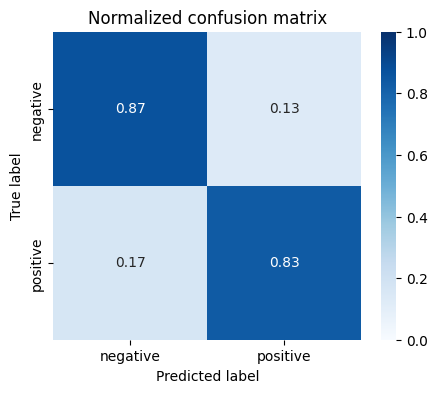

In [ ]:
cm_avg = cm_total / 5 # average of the 5 trails

plot_confusion_matrix(cm_avg, labels=class_names, figsize=(5, 4)) #to plot the confusion matrix

Run the code below for F1, recall, precision over 5 trails

In [ ]:
# Calculate the average precision, recall, F1 score, and support across trials
precision_avg = np.mean(precision_array)
recall_avg = np.mean(recall_array)
f1_score_avg = np.mean(f1_score_array)
support_avg = np.mean(support_array)

# Print the results
print("Precision: {:.2f}".format(precision_avg))
print("Recall: {:.2f}".format(recall_avg))
print("F1 score: {:.2f}".format(f1_score_avg))

Precision: 0.86
Recall: 0.83
F1 score: 0.85


## Test network on new samples
---



In [ ]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [ ]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [ ]:
sent_dict = {0: 'negative', 1: 'positive'}

In [ ]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [ ]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [ ]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"

In [ ]:
new_reviews = [review_score_10, review_score_4, review_score_1]
scores = [10, 4, 1]

In [ ]:
## With LSTM

with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model.predict(indexed_review, seq_length, False)
        logits = tf.nn.softmax(logits)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative


In [ ]:
## With RNN

with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = rnn_model.predict(indexed_review, seq_length, False)
        logits = tf.nn.softmax(logits)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be positive
The sentiment for the review with score 1 was found to be positive
